In [1]:
#Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd

In [2]:
# Đọc dữ liệu từ file CSV
data = pd.read_csv('HSG Historical Data.csv')

# Đặt lại tên cột
data.columns=[ 'Date', 'Close', 'Open', 'High', 'Low', 'Vol', 'Change']

# data = pd.DataFrame(data)

# Tiền xử lý dữ liệu
data['Date'] = pd.to_datetime(data['Date'])
data['Close'] = data['Close'].apply(lambda x: float(x.replace(",", "")))
data['Open'] = data['Open'].apply(lambda x: float(x.replace(",", "")))
data['High'] = data['High'].apply(lambda x: float(x.replace(",", "")))
data['Low'] = data['Low'].apply(lambda x: float(x.replace(",", "")))
data['Vol'] = data['Vol'].apply(lambda x: float(x.rstrip('M').rstrip('K')) * 1e6 if 'M' in x else float(x.rstrip('K')) * 1e3)
data['Change'] = data['Change'].apply(lambda x: float(x.rstrip('%')))

# Sắp xếp dữ liệu tăng dần theo cột Date
data = data.sort_values('Date')

In [3]:
#Xem lại dữ liệu sau khi xử lý hoàn tất
data

,Date,Close,Open,High,Low,Vol,Change
1370,2017-12-01,13830.5,13772.9,13917.0,13657.6,4410000.0,0.84
1369,2017-12-04,14781.4,14061.0,14781.4,13830.5,13710000.0,6.88
1368,2017-12-05,14522.1,15040.7,15242.4,14522.1,12280000.0,-1.75
1367,2017-12-06,14896.6,14464.4,15069.5,14320.4,9470000.0,2.58
1366,2017-12-07,14666.1,15098.3,15184.8,14550.9,5520000.0,-1.55
...,...,...,...,...,...,...,...
4,2023-05-29,15700.0,15500.0,15700.0,15350.0,9600000.0,2.28
3,2023-05-30,15850.0,15800.0,16000.0,15600.0,13350000.0,0.96
2,2023-05-31,15400.0,15800.0,15850.0,15200.0,36230000.0,-2.84
1,2023-06-01,15200.0,15300.0,15350.0,14950.0,15030000.0,-1.30


In [4]:
# Chia dữ liệu thành tập huấn luyện, tập validation và tập kiểm tra
train_size = int(0.6 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [5]:
# Tạo ma trận dữ liệu
X_train = train_data[['High', 'Low','Close', 'Open', 'Vol']].values
X_val = val_data[['High', 'Low' , 'Close', 'Open', 'Vol']].values
X_test = test_data[['High', 'Low', 'Close', 'Open', 'Vol']].values

y_train = train_data['Close'].values
y_val = val_data['Close'].values
y_test = test_data['Close'].values


In [17]:
import numpy as np

best_score = float('inf')
best_k_factors = 0
best_factor_order = 0

for k_factors in range(1, 5):
    for factor_order in range(1, 6):
        # try:
            # Xây dựng The Dynamic Factor Model
            model = sm.tsa.DynamicFactor(X_train, k_factors=k_factors, factor_order=factor_order, enforce_stationarity=False)
            result = model.fit(maxiter=100)

            # Dự đoán giá cổ phiếu trên tập validation
            y_pred = result.predict(start=train_size, end=train_size+test_size-1)

             # Lấy cột close từ y_pred để tính toán độ chính xác
            y_pred_close = y_pred[:, 2]

            # Đánh giá độ chính xác dự đoán trên tập test
            score = np.mean((y_pred_close - y_test)**2)

            # Lưu lại giá trị tốt nhất
            if score < best_score:
                best_score = score
                best_k_factors = k_factors
                best_factor_order = factor_order

        # except np.linalg.LinAlgError as e:
        #     # Bỏ qua lỗi "LU decomposition error"
        #     continue

        # except ValueError as e:
        #     if "Non-stationary starting autoregressive parameters" in str(e):
        #       continue




In [18]:
best_k_factors

1

In [19]:
best_factor_order

1

In [ ]:
best_k_factors=4
best_factor_order=9

In [20]:

# Xây dựng The Dynamic Factor Model với giá trị tối ưu
best_factor_order = 0
model = sm.tsa.DynamicFactor(X_train, k_factors=best_k_factors, factor_order=best_factor_order)
result = model.fit()
# Dự đoán giá cổ phiếu trên tập kiểm tra
y_pred_test = result.predict(start=train_size, end=train_size+test_size)

# Dự đoán giá cổ phiếu trên tập kiểm tra
y_pred_val = result.predict(start=train_size+test_size, end=len(data)-1)



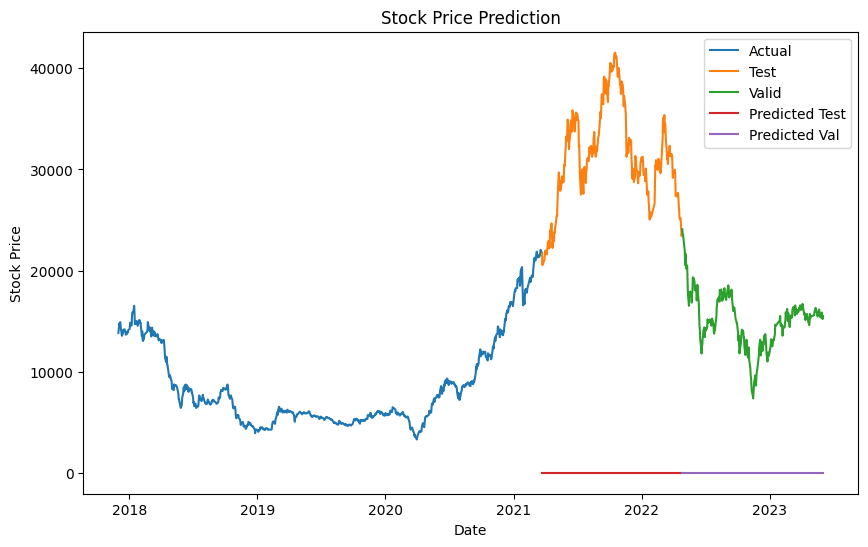

In [21]:

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(data['Date'][:train_size], train_data['Close'], label='Actual')
plt.plot(data['Date'][train_size:train_size+test_size], test_data['Close'], label='Test')
plt.plot(data['Date'][train_size+test_size:], val_data['Close'], label='Valid')
plt.plot(data['Date'][train_size:train_size+test_size+1], y_pred_test[:,2], label='Predicted Test')
plt.plot(data['Date'][train_size+test_size:], y_pred_val[:,2], label='Predicted Val')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.show()


In [15]:
from sklearn.metrics import mean_absolute_percentage_error

# Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val[:,2] - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred_test[1:,2] - y_test)**2))
vail_mape = mean_absolute_percentage_error(y_val, y_pred_val[:,2])
test_mape = mean_absolute_percentage_error(y_test, y_pred_test[1:,2])
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', vail_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 15226.211223495788
Testing RMSE: 31739.778799082258
Validation MAPE: 1.0
Testing MAPE: 1.0
